## Installing and Importing Required Libraries

In [ ]:
!pip install -q yfinance
!pip install langchain
!pip install langchain-core
!pip install langchain-community
!pip install langgraph
!pip install langchain_huggingface
!pip install tabulate
!pip uninstall -y pydantic
!pip install --no-cache-dir "pydantic>=2.11,<3"



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Found existing installation: pydantic 2.11.7
Uninstalling pydantic-2.11.7:
  Successfully uninstalled pydantic-2.11.7
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 KB 1.5 MB/s eta 0:00:001.6 MB/s eta 0:00:01


In [ ]:
import pandas as pd
import json
import datetime as dt
import base64
import requests
import numpy as np
from pathlib import Path
import matplotlib
matplotlib.use("Agg")  # safe, consistent backend
import matplotlib.pyplot as plt
from typing_extensions import Annotated
from operator import add  # used as list reducer
from typing import TypedDict, List, Dict
from pydantic import BaseModel, Field
from IPython.display import Image, display

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAI
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage
from langchain_experimental.agents import create_pandas_dataframe_agent
from langgraph.prebuilt import create_react_agent
from langchain.agents.agent_types import AgentType


## Importing the Dataset

In [ ]:
dataset = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv",
                      encoding = 'utf-8')
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Estabilishing a Connection With GridDB

In [ ]:
username = "USER_NAME"
password = "PASSWORD"
base_url = "GRIDDB_CLOUD_URL"

url = f"{base_url}/checkConnection"

credentials = f"{username}:{password}"
encoded_credentials = base64.b64encode(credentials.encode()).decode()

headers = {
    'Content-Type': 'application/json',  # Added this header to specify JSON content
    'Authorization': f'Basic {encoded_credentials}',
    'User-Agent': 'PostmanRuntime/7.29.0'
}

response = requests.get(url, headers=headers)

print(response.status_code)
print(response.text)

200



## Creating a Container for Titanic Data in GridDB

In [ ]:
dataset.insert(0, "SerialNo", dataset.index + 1)
dataset.columns.name = None
# Mapping pandas dtypes to GridDB types
type_mapping = {
    "int64":          "LONG",
    "float64":        "DOUBLE",
    "bool":           "BOOL",
    'datetime64': "TIMESTAMP",
    "object":         "STRING",
    "category":       "STRING",
}

# Generate the columns part of the payload dynamically
columns = []
for col, dtype in dataset.dtypes.items():
    griddb_type = type_mapping.get(str(dtype), "STRING")  # Default to STRING if unknown
    columns.append({
        "name": col,
        "type": griddb_type
    })

print(columns)

[{'name': 'SerialNo', 'type': 'LONG'}, {'name': 'PassengerId', 'type': 'LONG'}, {'name': 'Survived', 'type': 'LONG'}, {'name': 'Pclass', 'type': 'LONG'}, {'name': 'Name', 'type': 'STRING'}, {'name': 'Sex', 'type': 'STRING'}, {'name': 'Age', 'type': 'DOUBLE'}, {'name': 'SibSp', 'type': 'LONG'}, {'name': 'Parch', 'type': 'LONG'}, {'name': 'Ticket', 'type': 'STRING'}, {'name': 'Fare', 'type': 'DOUBLE'}, {'name': 'Cabin', 'type': 'STRING'}, {'name': 'Embarked', 'type': 'STRING'}]


In [ ]:
url = f"{base_url}/containers"
container_name = "titanic_db"
# Create the payload for the POST request
payload = json.dumps({
    "container_name": container_name,
    "container_type": "COLLECTION",
    "rowkey": True,  # Assuming the first column as rowkey
    "columns": columns
})


# Make the POST request to create the container
response = requests.post(url, headers=headers, data=payload)

# Print the response
print(f"Status Code: {response.status_code}")


Status Code: 201


## Inserting Titanic Dataset in GridDB

In [ ]:
url = f"{base_url}/containers/{container_name}/rows"
# Convert dataset to list of lists (row-wise) with proper formatting

def format_row(row):
    formatted = []
    for item in row:
        if pd.isna(item):
            formatted.append(None)  # Convert NaN to None
        elif isinstance(item, bool):
            formatted.append(str(item).lower())  # Convert True/False to true/false
        elif isinstance(item, (int, float)):
            formatted.append(item)  # Keep integers and floats as they are
        else:
            formatted.append(str(item))  # Convert other types to string
    return formatted

# Prepare rows with correct formatting
rows = [format_row(row) for row in dataset.values.tolist()]

# Create payload as a JSON string
payload = json.dumps(rows)

# Make the PUT request to add the rows to the container
response = requests.put(url, headers=headers, data=payload)

# Print the response
print(f"Status Code: {response.status_code}")
print(f"Response Text: {response.text}")


Status Code: 200
Response Text: {"count":891}


## Visualizing GridDB Results Using OpenAI API

In [ ]:
container_name = "titanic_db"

url = f"{base_url}/containers/{container_name}/rows"

# Define the payload for the query
payload = json.dumps({
    "offset": 0,           # Start from the first row
    "limit": 10000,         # Limit the number of rows returned
    "condition": "",       # No filtering condition (you can customize it)
    "sort": ""             # No sorting (you can customize it)
})

# Make the POST request to read data from the container
response = requests.post(url, headers=headers, data=payload)

# Check response status and print output
print(f"Status Code: {response.status_code}")
if response.status_code == 200:
    try:
        data = response.json()
        print("Data retrieved successfully!")

        # Convert the response to a DataFrame
        rows = data.get("rows", [])
        titanic_dataset = pd.DataFrame(rows, columns=[col for col in dataset.columns])

    except json.JSONDecodeError:
        print("Error: Failed to decode JSON response.")
else:
    print(f"Error: Failed to query data from the container. Response: {response.text}")

print(titanic_dataset.shape)
titanic_dataset.head()

Status Code: 200
Data retrieved successfully!
(891, 13)


,SerialNo,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [ ]:
avg = titanic_dataset.groupby('Survived')['Fare'].mean().round(2)
print(avg)


Survived
0    22.12
1    48.40
Name: Fare, dtype: float64


### Creating a LangGraph ReAct Agent for Data Visualization

In [ ]:
class State(TypedDict):
    question: str
    answer: str
    plots: Annotated[List[Dict[str, str]], add]


api_key = "YOUR_OPENAI_API_KEY"

llm = ChatOpenAI(model="gpt-4o",
                 api_key=api_key,
                temperature = 0)


In [ ]:
df_agent = create_pandas_dataframe_agent(llm,
                                      titanic_dataset,
                                      verbose=True,
                                      agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                                      allow_dangerous_code=True)


_LAST = {"fig": None}                # keep a handle to the last real figure

@tool("df_answer")
def df_answer(question: str) -> str:
    """
    Use the pandas DataFrame agent to compute/plot.
    IMPORTANT: do NOT call plt.show() or plt.close() in the generated code.
    """
    res = df_agent.invoke(
        question
    )

    # CAPTURE whichever figure the agent actually created
    fig_nums = plt.get_fignums()          # existing figures in this process
    if fig_nums:
        _LAST["fig"] = plt.figure(fig_nums[-1])   # latest real figure
    return res["output"]

In [ ]:

@tool("save_plot")
def save_plot(filename: str = "plot.png", dpi: int = 200, close: bool = True) -> str:
    """
    Save the most recent existing Matplotlib figure (not an empty gcf()).
    Returns {"plot": {"name": ..., "path": ...}} or {"error": ...}.
    """
    Path("plots").mkdir(exist_ok=True)
    fig = _LAST.get("fig")

    # Fallback: grab last live figure if we didn't capture yet
    if fig is None:
        nums = plt.get_fignums()
        if not nums:
            return json.dumps({"error": "no_figure", "message": "No active figure to save."})
        fig = plt.figure(nums[-1])

    # Render + save
    fig.tight_layout()
    try:
        fig.canvas.draw()                # ensure render
    except Exception:
        pass

    out = Path("plots") / filename
    fig.savefig(out, dpi=dpi, bbox_inches="tight")

    if close:
        plt.close(fig)                   # avoid accumulating figures

    return json.dumps({"plot": {"name": filename, "path": str(out.resolve())}})


In [ ]:

SYSTEM = """
You work over a Titanic pandas DataFrame.
- To compute answers or create charts, call `df_answer(question=...)`.
- If a plot should be saved, call `save_plot(filename=..., dpi=200)`.
- Keep text concise. If you saved a plot, you may echo the absolute path.
"""

react = create_react_agent(
    llm,
    tools=[df_answer, save_plot],
    prompt=SYSTEM,
)


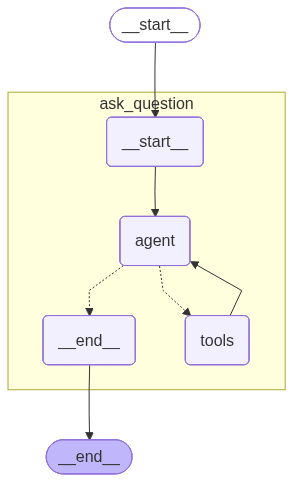

In [ ]:
def run_react(state: State) -> State:
    out = react.invoke({"messages": [("user", state["question"])]})

    msgs = out["messages"]
    final_text = msgs[-1].content

    new_plots = []
    for m in msgs:
        # Tool messages include the tool's return in `content`
        try:
            data = json.loads(getattr(m, "content", "") or "{}")
        except Exception:
            data = None
        if isinstance(data, dict) and "plot" in data:
            new_plots.append(data["plot"])  # {"name": "...", "path": "..."}

    return {"answer": final_text, "plots": new_plots}

graph_builder = StateGraph(State)
graph_builder.add_node("ask_question", run_react)
graph_builder.add_edge(START, "ask_question")
graph_builder.add_edge("ask_question", END)
graph = graph_builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### Testing the Agent and Generating Responses

In [ ]:
# A) plain Q&A
s = graph.invoke({"question": "What is the average Fare for passengers that survive and those who did not?"})
print(f"\nFinal Answer: {s['answer']}")



> Entering new AgentExecutor chain...
Thought: To find the average Fare for passengers who survived and those who did not, I need to group the dataframe by the 'Survived' column and then calculate the mean of the 'Fare' column for each group.
Action: python_repl_ast
Action Input: df.groupby('Survived')['Fare'].mean()Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64I now know the final answer.

Final Answer: The average Fare for passengers who did not survive is 22.12, and for those who survived, it is 48.40.

> Finished chain.

Final Answer: The average Fare for passengers who did not survive is 22.12, while for those who survived, it is 48.40.


In [ ]:
# B) plot + save (the agent will call save_plot internally)
s = graph.invoke({
    "question": ("Plot a bar chart of average Fare for passengers that survive and those who did not?"),
})
print(f"\nFinal Answer: {s['answer']}")
print("plots so far:", s["plots"])



> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...
To create a bar chart showing the average Fare for passengers grouped by their survival status, we can use the `groupby` method to calculate the average fare for each survival status and then plot the results using a bar chart. Let's proceed with these steps.

Thought: I will group the dataframe by the 'Survived' column, calculate the average fare for each group, and then plot the results using a bar chart.
Action: python_repl_ast
Action Input: 
```python
import matplotlib.pyplot as plt

# Group by 'Survived' and calculate the average 'Fare'
average_fare_by_survival = df.groupby('Survived')['Fare'].mean()

# Plotting the bar chart
average_fare_by_survival.plot(kind='bar', color=['red', 'green'])
plt.title('Average Fare by Survival Status')
plt.xlabel('Survived')
plt.ylabel('Average Fare')
plt.xticks(ticks=[0, 1], labels=['Did Not Survive', 'Survived'], rotation=0)
plt

<string>:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


I now know the final answer.

Final Answer: A bar chart has been created showing the average Fare for passengers grouped by their survival status. The chart displays two bars: one for passengers who did not survive and one for those who survived, with the average fare for each group.

> Finished chain.

Final Answer: The bar chart of average Fare by survival status has been saved. You can view it at the following path: `/home/mani/GridDB Projects/plots/average_fare_by_survival_status.png`.
plots so far: [{'name': 'average_fare_by_survival_status.png', 'path': '/home/mani/GridDB Projects/plots/average_fare_by_survival_status.png'}]
